# Hybrid ODE Learning

In this notebook we will examine how we can learn hybrid models, where partial mechanistic knowledge exists.

We will follow the example presented in https://edgarsmdn.github.io/MLCE_book/05_Hybrid_CSTR.html but using a simpler approach.

First, we will start with a blackbox **implicit** model:

In [112]:
from chelo.datasets.cstr_dataset import CSTRDataset
dataset = CSTRDataset(window=1)
dataset.load_data()
X, y = dataset.to_numpy()
print(X.shape, y.shape)
X = X.reshape(-1, 3)
print(X.shape, y.shape)

(29, 1, 3) (29, 3)
(29, 3) (29, 3)


We have 29 measurements for concentrations of 3 species.

In [113]:
import torch
from torch import nn

# First define a simple MLP for modelling the system

class MLP(nn.Module):
    def __init__(self, ):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3, 6)
        self.fc2 = nn.Linear(6, 3)

    def forward(self, input_states):
        x = self.fc1(input_states)
        x = 1 / (1 + torch.exp(-x))
        x = self.fc2(x)
        return x

Then we can proceed by modeling creating a helper class and setting initial conditions:

In [114]:
class SystemDynamics(nn.Module):
    def __init__(self):
        super().__init__()
        self.C_Ain = 0.7
        self.C_Bin = 0.3
        self.C_Xin = 0
        self.tau = 100
        self.mlp = MLP()

    def forward(self, t, state):
        res = self.mlp(state.view(1, 3))
        return res.view((-1, 3))
    
# Prepare Initial State
C_init = torch.tensor([0.5, 0.5, 0], dtype=torch.float32)
t = torch.linspace(0, 100, 29)

# Using a good init always helps
system_dynamics = SystemDynamics()
system_dynamics.mlp.fc1.weight.data.mul_(0.001)
system_dynamics.mlp.fc2.weight.data.mul_(0.001)
system_dynamics.mlp.fc1.bias.data.mul_(0)
system_dynamics.mlp.fc2.bias.data.mul_(0)

tensor([-0., -0., -0.])

Let's evaluate the initial solution:

In [115]:
from torchdiffeq import odeint

# Evaluate the initial solution
sol_init = odeint(system_dynamics, C_init, t).detach().numpy()
print(sol_init)


[[5.0000000e-01 5.0000000e-01 0.0000000e+00]
 [4.9938804e-01 5.0107211e-01 4.0792741e-04]
 [4.9877611e-01 5.0214422e-01 8.1585493e-04]
 [4.9816418e-01 5.0321633e-01 1.2237829e-03]
 [4.9755222e-01 5.0428843e-01 1.6317111e-03]
 [4.9694028e-01 5.0536048e-01 2.0396393e-03]
 [4.9632832e-01 5.0643259e-01 2.4475676e-03]
 [4.9571639e-01 5.0750470e-01 2.8554962e-03]
 [4.9510446e-01 5.0857681e-01 3.2634251e-03]
 [4.9449256e-01 5.0964892e-01 3.6713544e-03]
 [4.9388060e-01 5.1072103e-01 4.0792837e-03]
 [4.9326864e-01 5.1179314e-01 4.4872127e-03]
 [4.9265671e-01 5.1286525e-01 4.8951423e-03]
 [4.9204472e-01 5.1393735e-01 5.3030713e-03]
 [4.9143282e-01 5.1500946e-01 5.7110009e-03]
 [4.9082085e-01 5.1608157e-01 6.1189346e-03]
 [4.9020892e-01 5.1715368e-01 6.5268655e-03]
 [4.8959696e-01 5.1822573e-01 6.9347965e-03]
 [4.8898503e-01 5.1929784e-01 7.3427269e-03]
 [4.8837307e-01 5.2036995e-01 7.7506588e-03]
 [4.8776114e-01 5.2144206e-01 8.1585897e-03]
 [4.8714921e-01 5.2251416e-01 8.5665230e-03]
 [4.865372

Not much going on. So we can fit our model using the experimental data:

In [116]:
import tqdm

# Train the model
optimizer = torch.optim.Adam(system_dynamics.parameters(), lr=0.001)
losses = []
# Get the data here
gt = torch.tensor(X)

for i in range(1000):
    optimizer.zero_grad()

    sol = odeint(system_dynamics, C_init, t, )
    loss = torch.sum((sol - gt) ** 2)
    loss.backward()
    losses.append(loss.item())
    if i % 100 == 0:
        print(loss)
    optimizer.step()
optimizer = torch.optim.Adam(system_dynamics.parameters(), lr=0.0001)

for i in range(500):
    optimizer.zero_grad()

    sol = odeint(system_dynamics, C_init, t, )
    loss = torch.sum((sol - gt) ** 2)
    loss.backward()
    losses.append(loss.item())
    if i % 100 == 0:
        print(loss)
    optimizer.step()

tensor(5.2925, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.5827, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.5765, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.5634, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.5312, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.4590, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.3377, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.2049, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.1099, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.0573, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.0302, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.0237, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.0172, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.0120, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.0083, dtype=torch.float64, grad_fn=<SumBackward0>)


Learning seems to work. Let's examine the loss:

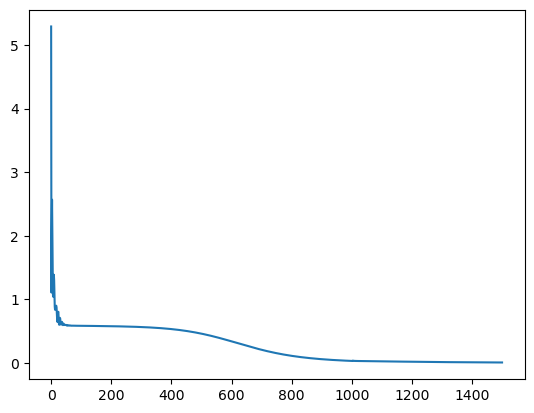

In [117]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)


Now that we learned the ODE that describes the system we can predict its behavior:

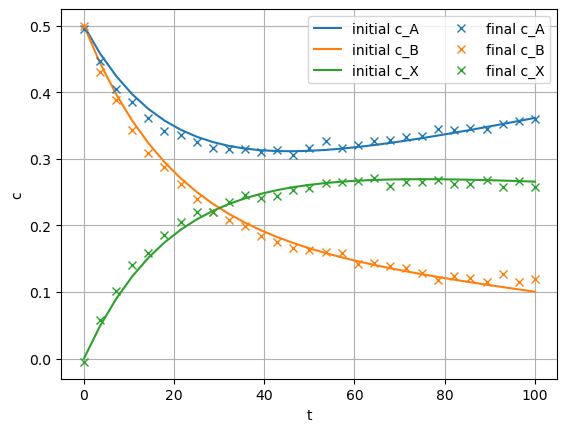

In [118]:
# Evaluate the final solution
sol_opt_blacbox_implicit = odeint(system_dynamics, C_init, t).detach().numpy()

# plot system trajectories
plt.figure(1)
plt.plot(t, sol_opt_blacbox_implicit[:,:3])
plt.gca().set_prop_cycle(None)
plt.plot(t, X, 'x')
plt.xlabel('t')
plt.ylabel('c')
plt.legend(('initial c_A', 'initial c_B', 'initial c_X',
            'final c_A', 'final c_B', 'final c_X'), loc='upper right',ncol=2) # make a legend
plt.grid()
plt.show()


The solution is generally ok. But can we do better?

Since we know the dynamics of a CSTR we can encode this knowledge and just learn the reaction rate between A and B under various conditions:


In [119]:
class MLP(nn.Module):
    def __init__(self, ):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3, 6)
        self.fc2 = nn.Linear(6, 1)

    def forward(self, input_states):
        x = self.fc1(input_states)
        x = 1 / (1 + torch.exp(-x))
        x = self.fc2(x)
        return x


Note we are going to only predict the reaction rate.

In [120]:
class SystemDynamics(nn.Module):
    def __init__(self):
        super().__init__()
        self.C_Ain = 0.7
        self.C_Bin = 0.3
        self.C_Xin = 0
        self.tau = 100
        self.n_states = 3
        self.mlp = MLP()


    def forward(self, t, state):
        Ca, Cb, Cx = state
        r = self.mlp(state.view(1, 3))[0,0]
        dCa = (self.C_Ain - Ca) / self.tau - r
        dCb = (self.C_Bin - Cb) / self.tau - r
        dCx = (self.C_Xin - Cx) / self.tau + r
        return torch.stack((dCa, dCb, dCx))


In [121]:

# Prepare Initial State
C_init = torch.tensor([0.5, 0.5, 0], dtype=torch.float32)
t = torch.linspace(0, 100, 29)

system_dynamics = SystemDynamics()
system_dynamics.mlp.fc1.weight.data.mul_(0.001)
system_dynamics.mlp.fc2.weight.data.mul_(0.001)
system_dynamics.mlp.fc1.bias.data.mul_(0)
system_dynamics.mlp.fc2.bias.data.mul_(0)

# Train the model
optimizer = torch.optim.Adam(system_dynamics.parameters(), lr=0.001)
losses_hybrid = []

for i in range(1000):
    optimizer.zero_grad()

    sol = odeint(system_dynamics, C_init, t, )
    loss = torch.sum((sol - gt) ** 2)
    loss.backward()
    losses_hybrid.append(loss.item())
    if i % 100 == 0:
        print(loss)
    optimizer.step()
   
optimizer = torch.optim.Adam(system_dynamics.parameters(), lr=0.0001)

for i in range(500):
    optimizer.zero_grad()

    sol = odeint(system_dynamics, C_init, t, )
    loss = torch.sum((sol - gt) ** 2)
    loss.backward()
    losses_hybrid.append(loss.item())
    if i % 100 == 0:
        print(loss)
    optimizer.step()


# Evaluate the final solution
sol_opt_hybrid = odeint(system_dynamics, C_init, t).detach().numpy()

tensor(4.2783, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.3388, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.3335, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.3239, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.3041, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.2654, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.2036, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.1326, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.0753, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.0397, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.0207, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.0117, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.0057, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.0033, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.0024, dtype=torch.float64, grad_fn=<SumBackward0>)


Let's compare first the losses:

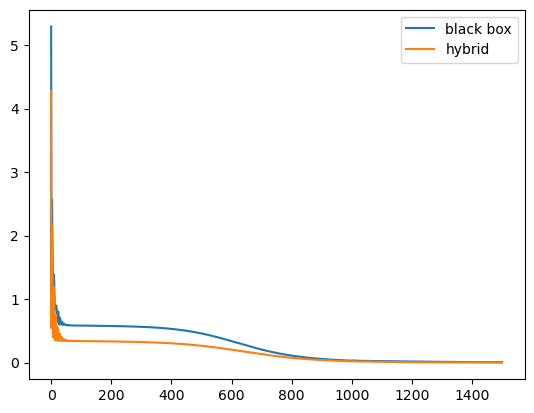

In [122]:
plt.figure(2)
plt.plot(losses)
plt.plot(losses_hybrid)
plt.legend(['black box', 'hybrid'])

Let's compare all solutions:

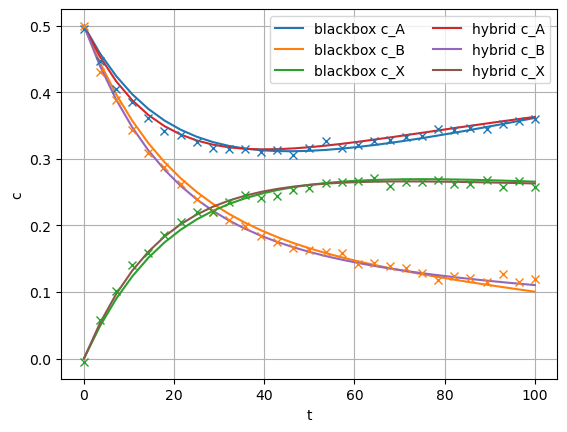

In [123]:
# plot system trajectories
plt.figure(1)
plt.plot(t, sol_opt_blacbox_implicit[:,:3])
plt.plot(t, sol_opt_hybrid[:,:3])
plt.gca().set_prop_cycle(None)
plt.plot(t, X, 'x')
plt.xlabel('t')
plt.ylabel('c')
plt.legend(('blackbox c_A', 'blackbox c_B', 'blackbox c_X',
            'hybrid c_A', 'hybrid c_B', 'hybrid c_X'), loc='upper right',ncol=2) # make a legend
plt.grid()
plt.show()
